## Goal:
The goal is to see whether these clusters match known breast cancer subtypes and marker genes, and whether the refined clusters are easier to interpret than plain Leiden
## Conclusion:
- Overall, Leiden class behaves reasonably on the BRCA feature graph and recovers modules that align with known PAM50 biology. Pure Leiden finds a few very large moduyle that already separate certain groups. 
- The hybrid Leiden+KMeans version breaks these into smaller, more focused groups that are tighter in embedding space. 
- Several of these refined modules show strong differences across PAM50 subtypes. This may suggest they capture meaningful subtype-specific patterns. 
- This notebook provides a concrete example that the new Leiden class and its refinement step might produce biologically interpretable clusters on a real multi-omics dataset.

### Load BRCA data and build the feature–feature graph

Load the TCGA BRCA omics tables from BioNeuralNet, select high-variance features, merge them into a single matrix (patients × features), and build a cosine k-NN graph between features.


In [ ]:
import pandas as pd
import numpy as np
from bioneuralnet.datasets import DatasetLoader
from bioneuralnet.utils import select_top_k_variance
from bioneuralnet.utils.graph import gen_similarity_graph
import networkx as nx

# Load BRCA
brca = DatasetLoader("brca")
rna = brca.data["rna"]
mirna = brca.data["mirna"]
meth = brca.data["meth"]
pam50 = brca.data["pam50"]
clinical = brca.data["clinical"]

# Feature selection
rna_sel = select_top_k_variance(rna,  k=1000)
meth_sel = select_top_k_variance(meth, k=1000)
mirna_sel = mirna

# Merge omics along columns (patients x features)
merged_brca = pd.concat([rna_sel, meth_sel, mirna_sel], axis=1)
print("merged_brca shape:", merged_brca.shape)  # (N_patients, 2503 features)

# Build cosine kNN feature graph (features x features)
A_feature = gen_similarity_graph(
    merged_brca,
    k=15,
    metric="cosine",
    mutual=True,
    self_loops=False
)
print("A_feature shape:", A_feature.shape)



2025-11-18 09:49:05,376 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
2025-11-18 09:49:05,376 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs after median imputation
2025-11-18 09:49:05,376 - bioneuralnet.utils.preprocess - INFO - [Zero-Var]: 0 columns dropped due to zero variance
2025-11-18 09:49:05,424 - bioneuralnet.utils.preprocess - INFO - Selected top 1000 features by variance
2025-11-18 09:49:06,684 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
2025-11-18 09:49:06,684 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs after median imputation
2025-11-18 09:49:06,684 - bioneuralnet.utils.preprocess - INFO - [Zero-Var]: 0 columns dropped due to zero variance
2025-11-18 09:49:06,744 - bioneuralnet.utils.preprocess - INFO - Selected top 1000 features by variance


merged_brca shape: (769, 2503)
A_feature shape: (2503, 2503)


### Convert the adjacency matrix to a weighted NetworkX graph

Turn the dense feature–feature adjacency matrix into a sparse NetworkX graph with edge weights. This is the graph that Leiden will run on.


In [7]:
def adjacency_to_nx(A, weight_threshold=0.0) -> nx.Graph:
    G = nx.Graph()
    nodes = list(A.index)  # feature names
    G.add_nodes_from(nodes)

    M = A.values
    rows, cols = np.nonzero(M)

    for i, j in zip(rows, cols):
        if i >= j:
            continue  # avoid duplicates / self-loops
        w = float(M[i, j])
        if w <= weight_threshold:
            continue
        u = nodes[i]
        v = nodes[j]
        G.add_edge(u, v, weight=w)

    return G

G_feature = adjacency_to_nx(A_feature, weight_threshold=0.0)
print(f"Graph: {G_feature.number_of_nodes()} nodes, {G_feature.number_of_edges()} edges")


Graph: 2503 nodes, 2959 edges


### Train a GNN to get embeddings for each feature

Feed the feature graph and merged omics matrix into `GNNEmbedding` to learn a low-dimensional embedding vector for each feature (gene). These embeddings will later be used by Leiden + KMeans.


In [ ]:
from bioneuralnet.network_embedding import GNNEmbedding

print("adjacency shape:", A_feature.shape)    # (2503, 2503)
print("omics_data shape:", merged_brca.shape) # (769, 2503)
print("pam50 shape:", pam50.shape, type(pam50))

# Just in case pam50 got converted to something weird
if not isinstance(pam50, (pd.Series, pd.DataFrame)):
    pam50 = pd.DataFrame(pam50)

# make it a single-column DF
if isinstance(pam50, pd.Series):
    pam50 = pam50.to_frame(name="pam50")

phenotype_col = pam50.columns[0]   # name of the single phenotype column

gnn = GNNEmbedding(
    adjacency_matrix=A_feature,
    omics_data=merged_brca,# N x D
    phenotype_data=pam50, # N x 1
    clinical_data=None, # drop clinical to avoid string issues
    phenotype_col=phenotype_col,
    tune=False,
    gpu=False,
)

gnn.fit()
emb_df = gnn.embed(as_df=True)
print("emb_df shape:", emb_df.shape)
print(emb_df.head())



2025-11-18 09:55:57,907 - bioneuralnet.network_embedding.gnn_embedding - INFO - Initialized GNNEmbedding. device=cpu
2025-11-18 09:55:57,908 - bioneuralnet.network_embedding.gnn_embedding - INFO - No output_dir provided; using temporary directory: C:\Users\Hiro\AppData\Local\Temp\tmp75o3olqc
2025-11-18 09:55:57,909 - bioneuralnet.network_embedding.gnn_embedding - INFO - Starting training process.
2025-11-18 09:55:57,909 - bioneuralnet.network_embedding.gnn_embedding - INFO - Preparing node features.
2025-11-18 09:55:57,909 - bioneuralnet.network_embedding.gnn_embedding - INFO - Found 2503 common features between network and omics data.


adjacency shape: (2503, 2503)
omics_data shape: (769, 2503)
pam50 shape: (769, 1) <class 'pandas.core.frame.DataFrame'>


2025-11-18 09:55:58,689 - bioneuralnet.network_embedding.gnn_embedding - WARNING - Eigenvector centrality failed for component size 509; defaulting to 0.
2025-11-18 09:55:58,782 - bioneuralnet.network_embedding.gnn_embedding - WARNING - Eigenvector centrality failed for component size 127; defaulting to 0.
2025-11-18 09:55:58,850 - bioneuralnet.network_embedding.gnn_embedding - WARNING - Eigenvector centrality failed for component size 17; defaulting to 0.
2025-11-18 09:55:58,879 - bioneuralnet.network_embedding.gnn_embedding - WARNING - Eigenvector centrality failed for component size 33; defaulting to 0.
2025-11-18 09:55:58,987 - bioneuralnet.network_embedding.gnn_embedding - WARNING - Eigenvector centrality failed for component size 110; defaulting to 0.
2025-11-18 09:55:58,993 - bioneuralnet.network_embedding.gnn_embedding - WARNING - Eigenvector centrality failed for component size 8; defaulting to 0.
2025-11-18 09:55:59,020 - bioneuralnet.network_embedding.gnn_embedding - WARNING

emb_df shape: (2503, 64)
                Embed_1   Embed_2   Embed_3   Embed_4   Embed_5  Embed_6  \
CPB1_1360      0.528233  0.494876  0.582231  0.000000  0.534602      0.0   
SCGB2A2_4250   0.615469  0.662112  0.585225  0.000000  0.619640      0.0   
SCGB1D2_10647  0.000000  0.000000  0.000000  0.696445  0.000000      0.0   
TFF1_7031      0.000000  0.000000  0.000000  0.021252  0.000000      0.0   
PIP_5304       0.000000  0.000000  0.000000  0.102861  0.000000      0.0   

               Embed_7  Embed_8   Embed_9  Embed_10  ...  Embed_55  Embed_56  \
CPB1_1360          0.0      0.0  0.000000  0.000000  ...  0.395141       0.0   
SCGB2A2_4250       0.0      0.0  0.000000  0.000000  ...  0.158426       0.0   
SCGB1D2_10647      0.0      0.0  0.575529  0.525534  ...  0.000000       0.0   
TFF1_7031          0.0      0.0  0.092349  0.105062  ...  0.000000       0.0   
PIP_5304           0.0      0.0  0.238567  0.224489  ...  0.000000       0.0   

               Embed_57  Embed_58  Em

In [ ]:
nodes = list(G_feature.nodes())
print("First 5 graph nodes:", nodes[:5])

print("First 5 emb_df index:", emb_df.index[:5])

missing_in_emb = set(nodes) - set(emb_df.index)
missing_in_graph = set(emb_df.index) - set(nodes)

print("Missing in embeddings:", len(missing_in_emb))
print("Missing in graph:", len(missing_in_graph))


First 5 graph nodes: ['CPB1_1360', 'SCGB2A2_4250', 'SCGB1D2_10647', 'TFF1_7031', 'PIP_5304']
First 5 emb_df index: Index(['CPB1_1360', 'SCGB2A2_4250', 'SCGB1D2_10647', 'TFF1_7031', 'PIP_5304'], dtype='object')
Missing in embeddings: 0
Missing in graph: 0


In [ ]:
emb_aligned = emb_df.loc[nodes].to_numpy()
print("emb_aligned shape:", emb_aligned.shape)


emb_aligned shape: (2503, 64)


## Exploring how graph construction choices affect clustering

In [19]:
def build_graph(k, mutual):
    A = gen_similarity_graph(
        merged_brca,
        k=k,
        metric="cosine",
        mutual=mutual,
        self_loops=False,
    )
    G = adjacency_to_nx(A, weight_threshold=0.0)
    print(f"[k={k}, mutual={mutual}] graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return A, G

configs = [
    (15, True),
    (20, True),
    (25, True),
    (20, False),
    (25, False),
]

graphs = {}
for k, mut in configs:
    A_k, G_k = build_graph(k, mut)
    graphs[(k, mut)] = (A_k, G_k)


[k=15, mutual=True] graph: 2503 nodes, 2959 edges
[k=20, mutual=True] graph: 2503 nodes, 4000 edges
[k=25, mutual=True] graph: 2503 nodes, 5085 edges
[k=20, mutual=False] graph: 2503 nodes, 26229 edges
[k=25, mutual=False] graph: 2503 nodes, 33030 edges


In [20]:
import numpy as np
import pandas as pd

def summarize_clusters(labels, name):
    unique, counts = np.unique(labels, return_counts=True)
    sizes = pd.Series(counts)
    print(f"{name}: {len(unique)} clusters")
    print("  size stats:", sizes.describe())
    print("  top 10 largest sizes:", sizes.sort_values(ascending=False).head(10).tolist())


## Scan across different graph constructions and different resolution values for Leiden
- a small grid search over graph hyperparameters; to see how many communities we get and how modularity reacts, before picking one configuration to study in detail

In [ ]:
from bioneuralnet.clustering import Leiden_upd
resolutions = [1.0, 0.5, 0.25, 0.1]

for (k, mut), (A_k, G_k) in graphs.items():
    print("="*70)
    print(f"Graph config: k={k}, mutual={mut}")
    nodes_k = list(G_k.nodes())
    emb_k = emb_df.loc[nodes_k].to_numpy()

    for res in resolutions:
        print(f"  -- resolution={res} --")
        lc = Leiden_upd(
            G=G_k,
            embeddings=emb_k,
            use_edge_weights=True,
            resolution=res,
            random_state=0,
        )
        labels_leiden = lc.run(refine_with_kmeans=False)
        summarize_clusters(labels_leiden, f"Leiden(k={k},mutual={mut},res={res})")
        print(f"  quality={lc.modularity_:.3f}")


2025-11-18 10:10:55,565 - __main__ - INFO - Built igraph from NetworkX: 2503 nodes, 2959 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-11-18 10:10:55,579 - __main__ - INFO - Leiden found 1321 communities on 2503 nodes (resolution=1.0).
2025-11-18 10:10:55,589 - __main__ - INFO - Built igraph from NetworkX: 2503 nodes, 2959 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-11-18 10:10:55,603 - __main__ - INFO - Leiden found 1311 communities on 2503 nodes (resolution=0.5).
2025-11-18 10:10:55,609 - __main__ - INFO - Built igraph from NetworkX: 2503 nodes, 2959 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-11-18 10:10:55,621 - __main__ - INFO - Leiden found 1306 communities on 2503 nodes (resolution=0.25).
2025-11-18 10:10:55,630 - __main__ - INFO - Built igraph from NetworkX: 2503 nodes, 2959 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-11-18 10:10:55,642 - __main__ - INFO - Leide

Graph config: k=15, mutual=True
  -- resolution=1.0 --
Leiden(k=15,mutual=True,res=1.0): 1321 clusters
  size stats: count    1321.000000
mean        1.894777
std         5.965073
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        97.000000
dtype: float64
  top 10 largest sizes: [97, 79, 73, 68, 67, 55, 49, 48, 46, 46]
  quality=1271.843
  -- resolution=0.5 --
Leiden(k=15,mutual=True,res=0.5): 1311 clusters
  size stats: count    1311.000000
mean        1.909230
std         7.487812
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       153.000000
dtype: float64
  top 10 largest sizes: [153, 112, 104, 89, 82, 58, 46, 46, 39, 37]
  quality=1294.537
  -- resolution=0.25 --
Leiden(k=15,mutual=True,res=0.25): 1306 clusters
  size stats: count    1306.000000
mean        1.916539
std         9.237517
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       259.000000
dtype:

2025-11-18 10:10:55,753 - __main__ - INFO - Built igraph from NetworkX: 2503 nodes, 5085 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-11-18 10:10:55,767 - __main__ - INFO - Leiden found 1063 communities on 2503 nodes (resolution=0.5).
2025-11-18 10:10:55,776 - __main__ - INFO - Built igraph from NetworkX: 2503 nodes, 5085 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-11-18 10:10:55,789 - __main__ - INFO - Leiden found 1052 communities on 2503 nodes (resolution=0.25).
2025-11-18 10:10:55,800 - __main__ - INFO - Built igraph from NetworkX: 2503 nodes, 5085 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-11-18 10:10:55,814 - __main__ - INFO - Leiden found 1047 communities on 2503 nodes (resolution=0.1).
2025-11-18 10:10:55,843 - __main__ - INFO - Built igraph from NetworkX: 2503 nodes, 26229 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-11-18 10:10:55,865 - __main__ - INFO - Leid

Leiden(k=25,mutual=True,res=1.0): 1070 clusters
  size stats: count    1070.000000
mean        2.339252
std         9.173102
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       143.000000
dtype: float64
  top 10 largest sizes: [143, 135, 101, 91, 77, 71, 63, 63, 60, 54]
  quality=1426.749
  -- resolution=0.5 --
Leiden(k=25,mutual=True,res=0.5): 1063 clusters
  size stats: count    1063.000000
mean        2.354657
std        11.649757
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       282.000000
dtype: float64
  top 10 largest sizes: [282, 129, 106, 97, 78, 77, 63, 60, 49, 40]
  quality=1459.528
  -- resolution=0.25 --
Leiden(k=25,mutual=True,res=0.25): 1052 clusters
  size stats: count    1052.000000
mean        2.379278
std        13.017213
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       315.000000
dtype: float64
  top 10 largest sizes: [315, 138, 124, 106

2025-11-18 10:10:55,948 - __main__ - INFO - Built igraph from NetworkX: 2503 nodes, 26229 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-11-18 10:10:55,961 - __main__ - INFO - Leiden found 21 communities on 2503 nodes (resolution=0.25).
2025-11-18 10:10:55,996 - __main__ - INFO - Built igraph from NetworkX: 2503 nodes, 26229 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-11-18 10:10:56,014 - __main__ - INFO - Leiden found 20 communities on 2503 nodes (resolution=0.1).
2025-11-18 10:10:56,044 - __main__ - INFO - Built igraph from NetworkX: 2503 nodes, 33030 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-11-18 10:10:56,066 - __main__ - INFO - Leiden found 19 communities on 2503 nodes (resolution=1.0).
2025-11-18 10:10:56,097 - __main__ - INFO - Built igraph from NetworkX: 2503 nodes, 33030 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-11-18 10:10:56,114 - __main__ - INFO - Leiden 

Leiden(k=20,mutual=False,res=0.25): 21 clusters
  size stats: count     21.000000
mean     119.190476
std      251.394236
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max      911.000000
dtype: float64
  top 10 largest sizes: [911, 584, 523, 297, 172, 1, 1, 1, 1, 1]
  quality=2312.334
  -- resolution=0.1 --
Leiden(k=20,mutual=False,res=0.1): 20 clusters
  size stats: count      20.00000
mean      125.15000
std       355.42847
min         1.00000
25%         1.00000
50%         1.00000
75%         1.00000
max      1533.00000
dtype: float64
  top 10 largest sizes: [1533, 502, 294, 158, 1, 1, 1, 1, 1, 1]
  quality=2444.544
Graph config: k=25, mutual=False
  -- resolution=1.0 --
Leiden(k=25,mutual=False,res=1.0): 19 clusters
  size stats: count     19.000000
mean     131.736842
std      149.178432
min        1.000000
25%        1.000000
50%        1.000000
75%      260.000000
max      396.000000
dtype: float64
  top 10 largest sizes: [396, 377, 299, 267, 

2025-11-18 10:10:56,162 - __main__ - INFO - Leiden found 16 communities on 2503 nodes (resolution=0.25).
2025-11-18 10:10:56,197 - __main__ - INFO - Built igraph from NetworkX: 2503 nodes, 33030 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-11-18 10:10:56,213 - __main__ - INFO - Leiden found 14 communities on 2503 nodes (resolution=0.1).


Leiden(k=25,mutual=False,res=0.25): 16 clusters
  size stats: count     16.000000
mean     156.437500
std      264.093157
min        1.000000
25%        1.000000
50%        1.000000
75%      210.250000
max      917.000000
dtype: float64
  top 10 largest sizes: [917, 556, 370, 298, 181, 171, 1, 1, 1, 1]
  quality=2297.943
  -- resolution=0.1 --
Leiden(k=25,mutual=False,res=0.1): 14 clusters
  size stats: count      14.000000
mean      178.785714
std       417.265674
min         1.000000
25%         1.000000
50%         1.000000
75%       123.250000
max      1532.000000
dtype: float64
  top 10 largest sizes: [1532, 497, 300, 164, 1, 1, 1, 1, 1, 1]
  quality=2458.757


## Based on the previous sweep, we pick one graph configuration that looks reasonable

In [ ]:
# k=25, mutual=False, resolution=0.25
A_best, G_best = graphs[(25, False)]
nodes_best = list(G_best.nodes())
emb_best = emb_df.loc[nodes_best].to_numpy()

lc_best = Leiden_upd(
    G=G_best,
    embeddings=emb_best,
    use_edge_weights=True,
    resolution=0.25,
    random_state=0,
)

labels_leiden_best = lc_best.run(refine_with_kmeans=False)
labels_hybrid_best = lc_best.run(refine_with_kmeans=True, max_k_per_community=3)

print("Best pure Leiden communities:", len(set(labels_leiden_best)))
print("Best hybrid clusters:", len(set(labels_hybrid_best)))

summarize_clusters(labels_leiden_best, "Best Leiden")
summarize_clusters(labels_hybrid_best, "Best Hybrid")
print("Best Leiden quality:", lc_best.modularity_)


2025-11-18 10:12:20,337 - __main__ - INFO - Built igraph from NetworkX: 2503 nodes, 33030 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-11-18 10:12:20,354 - __main__ - INFO - Leiden found 16 communities on 2503 nodes (resolution=0.25).
2025-11-18 10:12:20,507 - __main__ - INFO - Hybrid Leiden+KMeans produced 28 clusters (base communities: 16).


Best pure Leiden communities: 16
Best hybrid clusters: 28
Best Leiden: 16 clusters
  size stats: count     16.000000
mean     156.437500
std      264.093157
min        1.000000
25%        1.000000
50%        1.000000
75%      210.250000
max      917.000000
dtype: float64
  top 10 largest sizes: [917, 556, 370, 298, 181, 171, 1, 1, 1, 1]
Best Hybrid: 28 clusters
  size stats: count     28.000000
mean      89.392857
std      109.720972
min        1.000000
25%        1.000000
50%       55.500000
75%      125.250000
max      436.000000
dtype: float64
  top 10 largest sizes: [436, 331, 249, 203, 190, 157, 150, 117, 99, 88]
Best Leiden quality: 2297.9427440614586


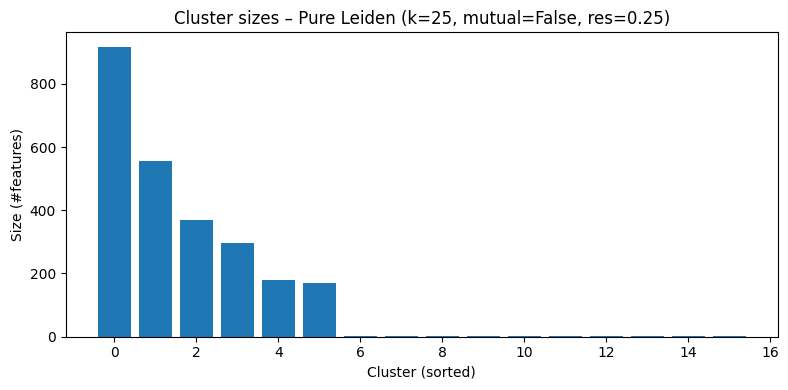

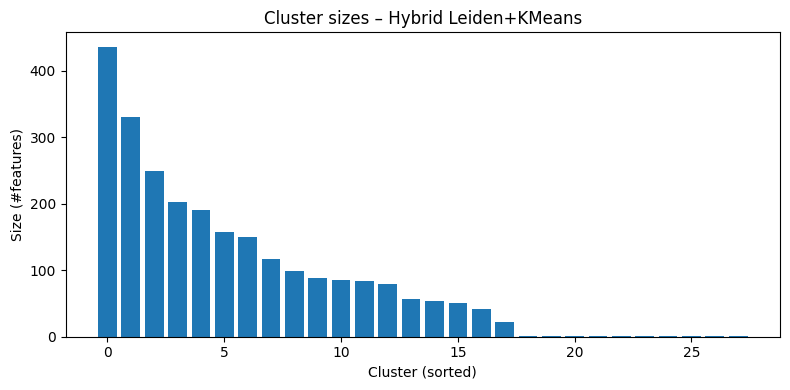

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def cluster_sizes(labels):
    _, counts = np.unique(labels, return_counts=True)
    return np.sort(counts)[::-1]

sizes_leiden = cluster_sizes(labels_leiden_best)
sizes_hybrid = cluster_sizes(labels_hybrid_best)


plt.figure(figsize=(8, 4))
plt.bar(np.arange(len(sizes_leiden)), sizes_leiden)
plt.xlabel("Cluster (sorted)")
plt.ylabel("Size (#features)")
plt.title("Cluster sizes – Pure Leiden (k=25, mutual=False, res=0.25)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(np.arange(len(sizes_hybrid)), sizes_hybrid)
plt.xlabel("Cluster (sorted)")
plt.ylabel("Size (#features)")
plt.title("Cluster sizes – Hybrid Leiden+KMeans")
plt.tight_layout()
plt.show()


In [ ]:
from umap import UMAP

umap = UMAP(n_components=2, random_state=0)
emb_2d = umap.fit_transform(emb_best)


x, y = emb_2d[:, 0], emb_2d[:, 1]


c:\Users\Hiro\gnnProject\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


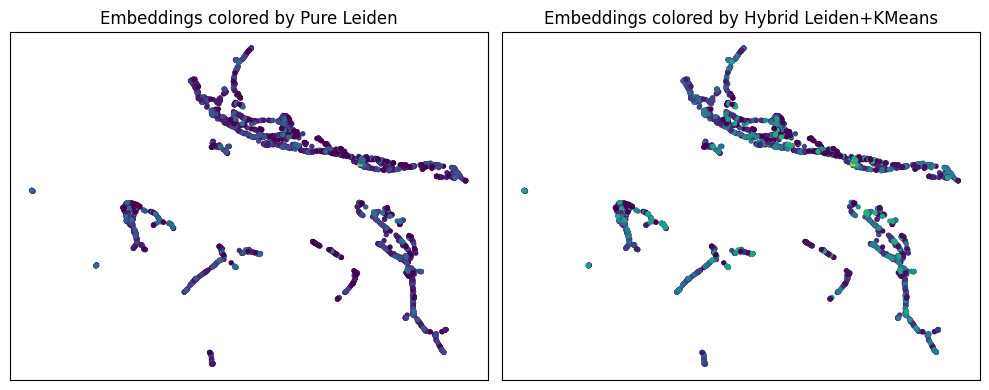

In [29]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(x, y, c=labels_leiden_best, s=8)
plt.title("Embeddings colored by Pure Leiden")
plt.xticks([]); plt.yticks([])

plt.subplot(1, 2, 2)
plt.scatter(x, y, c=labels_hybrid_best, s=8)
plt.title("Embeddings colored by Hybrid Leiden+KMeans")
plt.xticks([]); plt.yticks([])

plt.tight_layout()
plt.show()


## Compute modularity with NetworkX for pure and hybrid labels

In [ ]:
from networkx.algorithms import community

def nx_modularity(G, labels):
    # labels: array of cluster IDs aligned with nodes_best
    clusters = {}
    for node, c in zip(nodes_best, labels):
        clusters.setdefault(c, []).append(node)
    communities = [set(v) for v in clusters.values()]
    return community.modularity(G, communities, weight="weight")

mod_pure = lc_best.modularity_
mod_hybrid = nx_modularity(G_best, labels_hybrid_best)

print("Graph modularity (pure Leiden):", mod_pure)
print("Graph modularity (hybrid):", mod_hybrid)


Graph modularity (pure Leiden): 2297.9427440614586
Graph modularity (hybrid): 0.27099936737810915


In [ ]:
mod_pure_nx = nx_modularity(G_best, labels_leiden_best)
mod_hybrid_nx = nx_modularity(G_best, labels_hybrid_best)
print("NX modularity pure:", mod_pure_nx)
print("NX modularity hybrid:", mod_hybrid_nx)


NX modularity – pure: 0.682048504543489
NX modularity – hybrid: 0.27099936737810915


## Internal clustering metrics in embedding space

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

def filter_small_clusters(X, labels, min_size=2):
    labels = np.asarray(labels)
    X = np.asarray(X)
    _, counts = np.unique(labels, return_counts=True)
    big_clusters = {c for c, cnt in zip(*np.unique(labels, return_counts=True)) 
                    if cnt >= min_size}
    mask = np.array([l in big_clusters for l in labels])
    return X[mask], labels[mask]

# Embedding space
X_emb = emb_best

X_pure,   lab_pure = filter_small_clusters(X_emb, labels_leiden_best, min_size=2)
X_hybrid, lab_hybrid = filter_small_clusters(X_emb, labels_hybrid_best, min_size=2)

sil_pure = silhouette_score(X_pure, lab_pure)
sil_hybrid = silhouette_score(X_hybrid, lab_hybrid)

db_pure = davies_bouldin_score(X_pure, lab_pure)
db_hybrid = davies_bouldin_score(X_hybrid, lab_hybrid)

print("Silhouette (embedding) pure:",   sil_pure)
print("Silhouette (embedding) hybrid:", sil_hybrid)
print("Davies–Bouldin (embedding) pure:",   db_pure)
print("Davies–Bouldin (embedding) hybrid:", db_hybrid)


Silhouette (embedding) – pure: -0.15911588072776794
Silhouette (embedding) – hybrid: -0.15558862686157227
Davies–Bouldin (embedding) – pure: 26.497195127739705
Davies–Bouldin (embedding) – hybrid: 15.096237496914435


## Silhouette in expression space (feat, patient), cluster structure in expression space

In [ ]:
# Expression-space representations for features
X_expr = merged_brca.T.loc[nodes_best].to_numpy() # features x patients

X_pure_expr, lab_pure_expr = filter_small_clusters(X_expr, labels_leiden_best)
X_hybrid_expr, lab_hybrid_expr = filter_small_clusters(X_expr, labels_hybrid_best)

sil_pure_expr = silhouette_score(X_pure_expr, lab_pure_expr)
sil_hybrid_expr = silhouette_score(X_hybrid_expr, lab_hybrid_expr)

print("Silhouette (expression) – pure:",   sil_pure_expr)
print("Silhouette (expression) – hybrid:", sil_hybrid_expr)


Silhouette (expression) – pure: -0.006127461195258838
Silhouette (expression) – hybrid: -0.11376388287653869


## Biological validation for the hybrid clustering
- tells us which are strongly associated with known breast cancer substypes (Luma, etac)

In [ ]:
from sklearn.decomposition import PCA
import scipy.stats as stats

# Make a DataFrame of labels aligned with features
cluster_df = pd.DataFrame({
    "feature": nodes_best,
    "cluster_hybrid": labels_hybrid_best,
})
cluster_df.set_index("feature", inplace=True)

subtypes = pam50.iloc[:, 0] # "LumA", "LumB", etc.

def module_eigengene(features):
    # features: list of feature names
    X = merged_brca[features]
    # center features
    X_centered = X - X.mean(axis=0)
    pca = PCA(n_components=1)
    eig = pca.fit_transform(X_centered)[:, 0]  # (patients,)
    return pd.Series(eig, index=merged_brca.index)

results = []

for c_id in sorted(cluster_df["cluster_hybrid"].unique()):
    feats = cluster_df.index[cluster_df["cluster_hybrid"] == c_id].tolist()
    if len(feats) < 5:
        continue  # skip tiny modules

    eig = module_eigengene(feats)

    # ANOVA across PAM50 subtypes
    groups = [eig[subtypes == s] for s in subtypes.unique()]
    f_stat, p_val = stats.f_oneway(*groups)
    results.append((c_id, len(feats), f_stat, p_val))

res_df = pd.DataFrame(results, columns=["cluster_id", "size", "Fstat", "pval"]).sort_values("pval")
print(res_df.head(10))


    cluster_id  size       Fstat           pval
6            6   203  931.440228  4.952425e-292
7            7    79  819.834871  1.146603e-274
8            8    88  795.648321  1.187808e-270
1            1   331  223.689435  5.019494e-127
0            0   436  222.147981  2.075407e-126
12          12    42  200.128837  2.409008e-117
14          14    54  162.415843  1.433380e-100
2            2   150  154.214830   1.094501e-96
3            3   249  153.009978   4.143525e-96
13          13    85  150.783928   4.907468e-95


## Biological validation for the pure leiden communities
- tells us which are strongly associated with known breast cancer substypes (Luma, etac)

In [ ]:
from sklearn.decomposition import PCA
import scipy.stats as stats

# Make a DataFrame of labels aligned with columns (features) for pure leiden
cluster_df = pd.DataFrame({
    "feature": nodes_best,
    "cluster_pure": labels_leiden_best,
})
cluster_df.set_index("feature", inplace=True)

subtypes = pam50.iloc[:, 0]   # "LumA", "LumB", etc.

def module_eigengene(features):
    # features: list of feature names
    X = merged_brca[features]
    # center features
    X_centered = X - X.mean(axis=0)
    pca = PCA(n_components=1)
    eig = pca.fit_transform(X_centered)[:, 0]  # (patients,)
    return pd.Series(eig, index=merged_brca.index)

results = []

for c_id in sorted(cluster_df["cluster_pure"].unique()):
    feats = cluster_df.index[cluster_df["cluster_pure"] == c_id].tolist()
    if len(feats) < 5:
        continue  # skip tiny modules

    eig = module_eigengene(feats)

    # ANOVA across PAM50 subtypes
    groups = [eig[subtypes == s] for s in subtypes.unique()]
    f_stat, p_val = stats.f_oneway(*groups)
    results.append((c_id, len(feats), f_stat, p_val))

res_df = pd.DataFrame(results, columns=["cluster_id", "size", "Fstat", "pval"]).sort_values("pval")
print(res_df.head(10))


   cluster_id  size       Fstat           pval
2           2   370  938.790049  4.098337e-293
0           0   917  207.991520  1.224466e-120
4           4   181  176.894807  3.271311e-107
1           1   556  123.182180   4.071126e-81
3           3   298   91.480721   1.489087e-63
5           5   171   84.389361   2.328251e-59


## Checks how correlated genes are within the same cluster compared to genes in different clusters.

In [34]:
def avg_corr_within_between(labels):
    labels = np.asarray(labels)
    X = merged_brca.T.loc[nodes_best].to_numpy()  # features x patients
    C = np.corrcoef(X)  # feature-feature correlation

    same = []
    diff = []
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            if np.isnan(C[i, j]):
                continue
            if labels[i] == labels[j]:
                same.append(C[i, j])
            else:
                diff.append(C[i, j])

    return np.mean(same), np.mean(diff)

w_pure, b_pure   = avg_corr_within_between(labels_leiden_best)
w_hybrid, b_hybrid = avg_corr_within_between(labels_hybrid_best)

print("Pure Leiden:   avg within =", w_pure, " avg between =", b_pure)
print("Hybrid Leiden: avg within =", w_hybrid, " avg between =", b_hybrid)


Pure Leiden:   avg within = 0.2254665517909804  avg between = -0.009812755006475476
Hybrid Leiden: avg within = 0.2212682322024399  avg between = 0.0271774813746387


## Interpret the most significant module in terms of PAM50 genes
- The print shows which PAM50 genes are part of this highly subtype-associated module. A first direct link between the clustering and known subtype marker genes

In [ ]:
c_star = res_df.sort_values("pval").iloc[0]["cluster_id"]
feats_star = cluster_df.index[cluster_df["cluster_hybrid"] == c_star].tolist()
print("Cluster", c_star, "size:", len(feats_star))
print("Some features:", feats_star[:20])
#print(pam50)
def feature_symbols(features):
    return {f.split("_")[0] for f in features}

# a list of PAM50 genes taken from literature:
pam50_genes = set(["UBE2T", "BIRC5", "NUF2",
"CDC6","CCNB1","TYMS","MYBL2","CEP55","MELK","NDC80","RRM2","UBE2C","CENPF","PTTG1","EXO1","ORC6L","ORC6","ANLN","CCNE1","CDC20","MKI67","KIF2C","ACTR3B","MYC","EGFR","KRT5","PHGDH","CDH3","MIA","KRT17","FOXC1","SFRP1","KRT14","ESR1","SLC39A6","BAG1","MAPT","PGR","CXXC5",
"MLPH","BCL2","MDM2","NAT1","FOXA1","BLVRA","MMP11","GPR160","FGFR4","GRB7","TMEM45B",
"ERBB2"])
overlap = pam50_genes.intersection(feature_symbols(feats_star))
print("PAM50 genes in this module:", overlap)


Cluster 6.0 size: 203
Some features: ['TFF1_7031', 'PIP_5304', 'KCNJ3_3760', 'ANKRD30A_91074', 'CYP2B7P1_1556', 'SERPINA6_866', 'SLC30A8_169026', 'VSTM2A_222008', 'DHRS2_10202', 'TFAP2B_7021', 'CEACAM5_1048', 'C1orf64_149563', 'CGA_1081', 'CYP4F8_11283', 'AGR2_10551', 'C10orf82_143379', 'LRP2_4036', 'NPY1R_4886', 'SERPINA11_256394', 'GFRA1_2674']
PAM50 genes in this module: {'MLPH', 'NAT1'}


## PAM50 overlap for top hybrid and pure modules
- These last two loops walk through the top modules (by p-value) and check how many PAM50 genes each one contains
- Some pure leiden communities already collect many PAM50 genes of a given subtype.
- The hybrid method can break those big communities into smaller ones that still keep strong PAM50 signals, but might split Luminal vs Basal markers into separate modules

In [50]:
for _, row in res_df.sort_values("pval").head(10).iterrows():
    c_id = row["cluster_id"]
    feats = cluster_df.index[cluster_df["cluster_hybrid"] == c_id].tolist()
    overlap = pam50_genes & feature_symbols(feats)
    print(f"Cluster {int(c_id)}: size={len(feats)}, PAM50 overlap={overlap}")


Cluster 6: size=203, PAM50 overlap={'MLPH', 'NAT1'}
Cluster 7: size=79, PAM50 overlap={'FOXA1', 'PGR', 'MAPT'}
Cluster 8: size=88, PAM50 overlap={'ESR1', 'TMEM45B'}
Cluster 1: size=331, PAM50 overlap={'KRT17', 'SFRP1'}
Cluster 0: size=436, PAM50 overlap={'KRT5', 'CDH3', 'MIA', 'KRT14'}
Cluster 12: size=42, PAM50 overlap={'MIA'}
Cluster 14: size=54, PAM50 overlap=set()
Cluster 2: size=150, PAM50 overlap={'EGFR'}
Cluster 3: size=249, PAM50 overlap=set()
Cluster 13: size=85, PAM50 overlap=set()


In [48]:
for _, row in res_df.sort_values("pval").head(10).iterrows():
    c_id = row["cluster_id"]
    feats = cluster_df.index[cluster_df["cluster_pure"] == c_id].tolist()
    overlap = pam50_genes & feature_symbols(feats)
    print(f"Cluster {int(c_id)}: size={len(feats)}, PAM50 overlap={overlap}")

Cluster 2: size=370, PAM50 overlap={'TMEM45B', 'FOXA1', 'MAPT', 'NAT1', 'ESR1', 'MLPH', 'PGR'}
Cluster 0: size=917, PAM50 overlap={'KRT5', 'CDH3', 'MIA', 'KRT14', 'SFRP1', 'KRT17', 'EGFR'}
Cluster 4: size=181, PAM50 overlap={'MIA'}
Cluster 1: size=556, PAM50 overlap=set()
Cluster 3: size=298, PAM50 overlap={'FOXC1'}
Cluster 5: size=171, PAM50 overlap=set()
